In [1]:
import os
import datetime
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

import pathlib
import seaborn as sns

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_hub as hub

In [3]:
if tf.test.gpu_device_name(): 
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
   print("Please turn on Colab GPU Runtime")

Default GPU Device: /device:GPU:0


In [4]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [5]:
data_dir = pathlib.Path('/content/gdrive/MyDrive/CS4243/data')

image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3960


In [6]:
def get_dataset_partitions_tf(ds, ds_size, train_split=0.8, val_split=0.1, test_split=0.1):
    assert (train_split + test_split + val_split) == 1
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [7]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, seed=42, reshuffle_each_iteration=False)

In [8]:
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['carrying' 'normal' 'threat']


In [9]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(list_ds, image_count)

In [10]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())
print(tf.data.experimental.cardinality(test_ds).numpy())

3168
396
396


In [11]:
def get_label(file_path):
  # Convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)

def decode_img(img, image_size):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # Resize the image to the desired size
  return tf.image.resize(img, image_size)

def parse_image(file_path, image_size):
  label = get_label(file_path)
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img, image_size)
  return img, label

In [12]:
image_size = [299, 299]
batch_size = 32

In [13]:
train_ds = train_ds.map(lambda x: parse_image(x, image_size), num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(lambda x: parse_image(x, image_size), num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.map(lambda x: parse_image(x, image_size), num_parallel_calls=tf.data.AUTOTUNE)

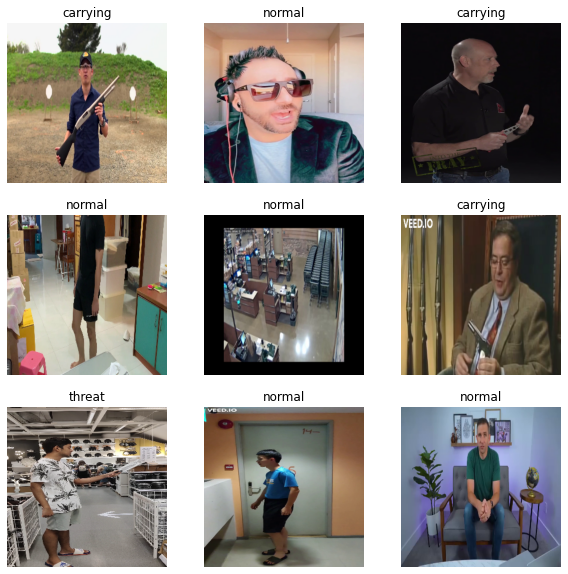

In [14]:
train_ds_iter = iter(train_ds)
plt.figure(figsize=(10, 10))
for i in range(9):
    image, label = next(train_ds_iter)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("uint8"))
    label = label
    plt.title(class_names[label])
    plt.axis("off")

In [15]:
normalize = layers.Rescaling(1./255)

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, batch_size=32, shuffle=False, augment=False, seed=123):
  # Resize and rescale all datasets.
  ds = ds.map(lambda x, y: (normalize(x), y), 
              num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(1000, seed=seed)

  # Batch all datasets.
  ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)

In [16]:
train_ds = prepare(train_ds, shuffle=True, augment=False)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)

In [17]:
image_height, image_width = image_size
print(image_height, image_width)

299 299


In [18]:
feature_extractor_link = "https://tfhub.dev/google/imagenet/inception_v3/feature_vector/5"

In [19]:
num_classes = len(class_names)

model = tf.keras.Sequential([
    hub.KerasLayer(feature_extractor_link, trainable=False),
    tf.keras.layers.Dense(120, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(84, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(num_classes, activation='softmax'),
])

model.build([None, image_height, image_width, 3])

In [20]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [21]:
epochs=3
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/3
99/99 [==============================] - 151s 995ms/step - loss: 0.9123 - accuracy: 0.5682 - val_loss: 0.7565 - val_accuracy: 0.6515
Epoch 2/3
99/99 [==============================] - 130s 952ms/step - loss: 0.7310 - accuracy: 0.6765 - val_loss: 0.6694 - val_accuracy: 0.7222
Epoch 3/3
99/99 [==============================] - 134s 963ms/step - loss: 0.6529 - accuracy: 0.7159 - val_loss: 0.6475 - val_accuracy: 0.7222


In [22]:
def plot_history(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.ylabel('Accuracy')
  plt.ylim([min(plt.ylim()),1])
  plt.title('Training and Validation Accuracy')

  plt.subplot(2, 1, 2)
  plt.plot(loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.ylabel('Cross Entropy')
  plt.ylim([0,2.0])
  plt.title('Training and Validation Loss')
  plt.xlabel('epoch')
  plt.show()

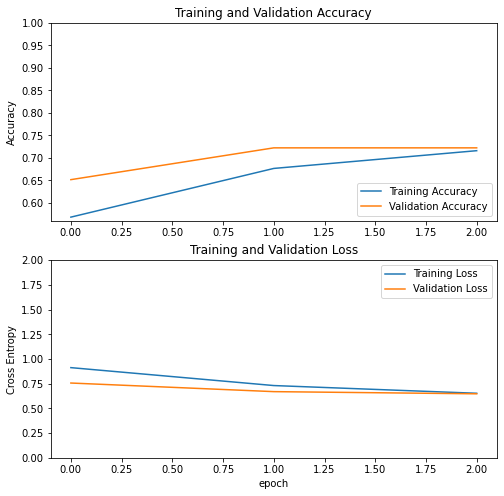

In [23]:
plot_history(history)

In [24]:
def get_actual_predicted_labels(model, dataset): 
  """
    Create a list of actual ground truth values and the predictions from the model.

    Args:
      dataset: An iterable data structure, such as a TensorFlow Dataset, with features and labels.

    Return:
      Ground truth and predicted values for a particular dataset.
  """
  actual = [labels for _, labels in dataset.unbatch()]
  predicted = model.predict(dataset)

  actual = tf.stack(actual, axis=0)
  predicted = tf.concat(predicted, axis=0)
  predicted = tf.argmax(predicted, axis=1)

  return actual, predicted

In [25]:
def plot_confusion_matrix(actual, predicted, labels, ds_type):
  cm = tf.math.confusion_matrix(actual, predicted)
  ax = sns.heatmap(cm, annot=True, fmt='g')
  ax.set_title('Confusion matrix of threat detection for ' + ds_type)
  ax.set_xlabel('Predicted')
  ax.set_ylabel('Actual')
  plt.xticks(rotation=90)
  plt.yticks(rotation=0) 
  ax.xaxis.set_ticklabels(labels)
  ax.yaxis.set_ticklabels(labels)

In [26]:
def save_model(model, name):
  export_path = '/content/gdrive/MyDrive/CS4243/saved_models/{}-{}'.format(name, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  model.save(export_path)

13/13 [==============================] - 16s 1s/step


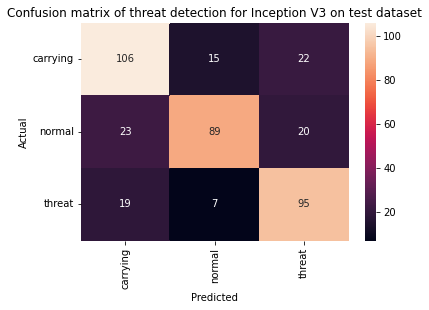

In [27]:
labels = class_names.tolist()

actual, predicted = get_actual_predicted_labels(model, test_ds)
plot_confusion_matrix(actual, predicted, labels, 'Inception V3 on test dataset')

In [28]:
save_model(model, 'untuned-inceptionv3')

In [29]:
model.evaluate(test_ds, return_dict=True)

13/13 [==============================] - 20s 1s/step - loss: 0.6471 - accuracy: 0.7323


{'loss': 0.6470980644226074, 'accuracy': 0.7323232293128967}